In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
BATCH_SIZE = 16

train_data = MNIST("./data",
                   train=True,
                   download=True,
                   transform=transforms.ToTensor())

train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

print("train data size: ",len(train_data))
print("train iteration number: ",len(train_data)//BATCH_SIZE)

100%|██████████| 9912422/9912422 [00:00<00:00, 416352496.51it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 117152508.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 158204080.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20396711.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

train data size:  60000
train iteration number:  3750


images_size: torch.Size([16, 1, 28, 28])
label: tensor([2, 9, 7, 0, 4, 7, 7, 5, 6, 4, 6, 0, 0, 7, 2, 9])


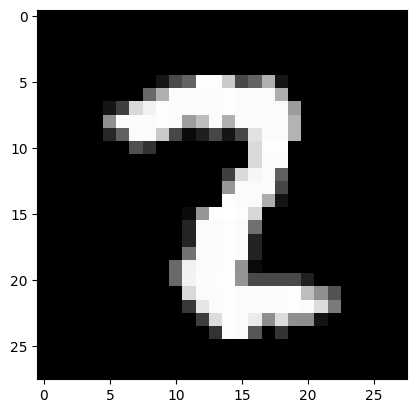

In [3]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())
print("label:",labels)
image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

In [4]:
class TwoConvBlock_2D(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding="same")
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.rl = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding="same")
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.rl(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.rl(x)
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = TwoConvBlock_2D(1,64)
    self.conv2 = TwoConvBlock_2D(64, 128)
    self.conv3 = TwoConvBlock_2D(128, 256)

    self.avgpool_2D = nn.AvgPool2d(2, stride = 2)
    self.global_avgpool_2D = nn.AvgPool2d(7)

    self.l1 = nn.Linear(256, 20)
    self.l2 = nn.Linear(20, 1)
    self.rl = nn.LeakyReLU()
    self.dropout1 = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.1)
    self.embed = nn.Embedding(10, 256)

  def forward(self, x, y):
    x = self.conv1(x)
    x = self.avgpool_2D(x)
    x = self.conv2(x)
    x = self.avgpool_2D(x)
    x = self.conv3(x)
    x = self.global_avgpool_2D(x)
    x = x.view(-1, 256)
    _x = x
    x = self.dropout1(x)
    x = self.l1(x)
    x = self.rl(x)
    x = self.dropout2(x)
    x = self.l2(x)

    _y = self.embed(y)
    xy = (_x*_y).sum(1, keepdim=True)

    x = x+xy
    x = torch.sigmoid(x)
    return x

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.l = nn.Linear(110, 49)
    self.dropout = nn.Dropout(0.2)
    self.TCB1 = TwoConvBlock_2D(1,512)
    self.TCB2 = TwoConvBlock_2D(512,256)
    self.TCB3 = TwoConvBlock_2D(256,128)
    self.UC1 = nn.ConvTranspose2d(512, 512, kernel_size =2, stride = 2)
    self.UC2 = nn.ConvTranspose2d(256, 256, kernel_size =2, stride = 2)
    self.conv1 = nn.Conv2d(128, 1, kernel_size = 2, padding="same")


  def forward(self, x, y):
    y = torch.nn.functional.one_hot(y.long(), num_classes=10).to(torch.float32)
    x = torch.cat([x, y], dim= 1)
    x = self.dropout(x)
    x = self.l(x)
    x = torch.reshape(x, (-1, 1, 7, 7))
    x = self.TCB1(x)
    x = self.UC1(x)
    x = self.TCB2(x)
    x = self.UC2(x)
    x = self.TCB3(x)
    x = self.conv1(x)
    x = torch.sigmoid(x)
    return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_D = Discriminator().to(device)
model_G = Generator().to(device)

true_labels = torch.ones(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)

criterion = nn.BCELoss()

optimizer_D = optim.Adam(model_D.parameters(), lr=0.00001)
optimizer_G = optim.Adam(model_G.parameters(), lr=0.00001)

epoch_num = 5
print_coef = 10
G_train_ratio = 2
train_length = len(train_data)

def calc_acc(pred):
  pred = torch.where(pred > 0.5, 1., 0.)
  acc = pred.sum()/pred.size()[0]
  return acc

history = {"loss_D": [], "loss_G": [], "acc_true": [], "acc_fake": []}
n = 0
m = 0
for epoch in range(epoch_num):
  train_loss_D = 0
  train_loss_G = 0
  train_acc_true = 0
  train_acc_fake = 0

  model_D.train()
  model_G.train()
  for i, data in enumerate(train_loader):
    optimizer_D.zero_grad()
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model_D(inputs, labels)
    loss_true = criterion(outputs, true_labels)
    acc_true = calc_acc(outputs)

    noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)
    noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)
    inputs_fake = model_G(noise, noise_label).to(device)
    outputs_fake = model_D(inputs_fake.detach(), noise_label)

    loss_fake = criterion(outputs_fake, fake_labels)
    acc_fake = calc_acc(outputs_fake)
    loss_D = loss_true + loss_fake
    loss_D.backward()
    optimizer_D.step()

    for _ in range(G_train_ratio):
      optimizer_G.zero_grad()
      noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)
      noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)
      inputs_fake = model_G(noise, noise_label).to(device)
      outputs_fake = model_D(inputs_fake, noise_label)
      loss_G = criterion(outputs_fake, true_labels)
      loss_G.backward()
      optimizer_G.step()

    train_loss_D += loss_D.item()
    train_loss_G += loss_G.item()
    train_acc_true += acc_true.item()
    train_acc_fake += acc_fake.item()
    n += 1
    history["loss_D"].append(loss_D.item())
    history["loss_G"].append(loss_G.item())
    history["acc_true"].append(acc_true.item())
    history["acc_fake"].append(acc_fake.item())

    if i % ((train_length//BATCH_SIZE)//print_coef) == (train_length//BATCH_SIZE)//print_coef - 1:
      print(f"epoch:{epoch+1}  index:{i+1}  loss_D:{train_loss_D/n:.10f}  loss_G:{train_loss_G/n:.10f}  acc_true:{train_acc_true/n:.10f}  acc_fake:{train_acc_fake/n:.10f}")

      n = 0
      train_loss_D = 0
      train_loss_G = 0
      train_acc_true = 0
      train_acc_fake = 0

print("finish training")


epoch:1  index:375  loss_D:1.3432292313  loss_G:5.4670383987  acc_true:0.7681666667  acc_fake:0.0758333333
epoch:1  index:750  loss_D:0.2083083803  loss_G:5.3933117218  acc_true:0.9606666667  acc_fake:0.0148333333
epoch:1  index:1125  loss_D:0.1671705306  loss_G:5.4443941046  acc_true:0.9760000000  acc_fake:0.0131666667
epoch:1  index:1500  loss_D:0.1666720582  loss_G:5.5532615598  acc_true:0.9765000000  acc_fake:0.0183333333
epoch:1  index:1875  loss_D:0.1448941021  loss_G:5.6823249868  acc_true:0.9771666667  acc_fake:0.0146666667
epoch:1  index:2250  loss_D:0.1232687924  loss_G:5.7542728545  acc_true:0.9820000000  acc_fake:0.0100000000
epoch:1  index:2625  loss_D:0.1330312203  loss_G:5.6902950783  acc_true:0.9781666667  acc_fake:0.0120000000
epoch:1  index:3000  loss_D:0.1139100943  loss_G:5.7071397572  acc_true:0.9836666667  acc_fake:0.0123333333
epoch:1  index:3375  loss_D:0.0989748453  loss_G:5.7288517831  acc_true:0.9860000000  acc_fake:0.0075000000
epoch:1  index:3750  loss_D:0.

Text(0, 0.5, 'acc_fake')

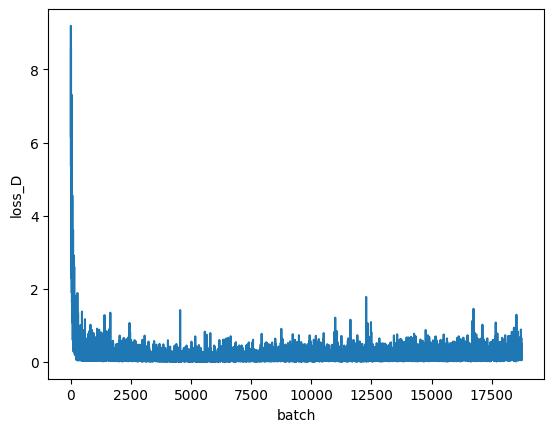

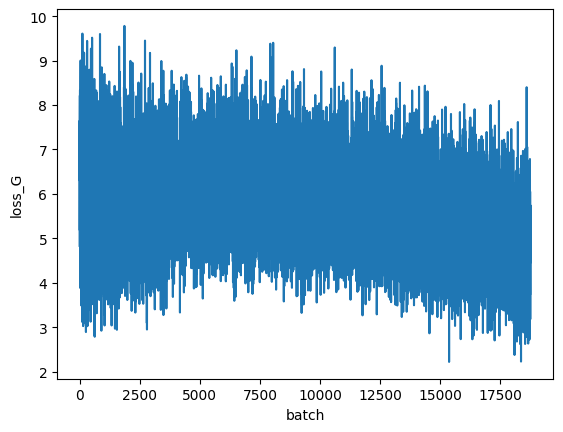

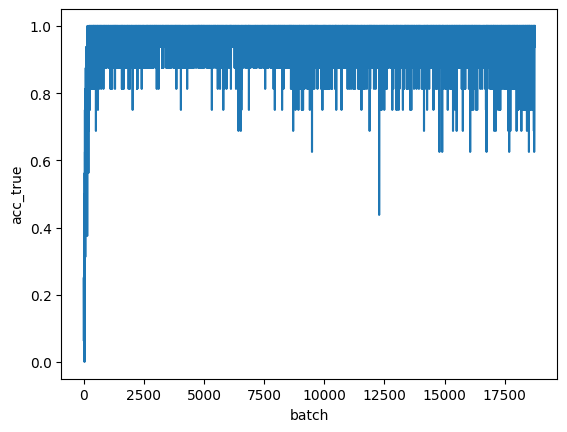

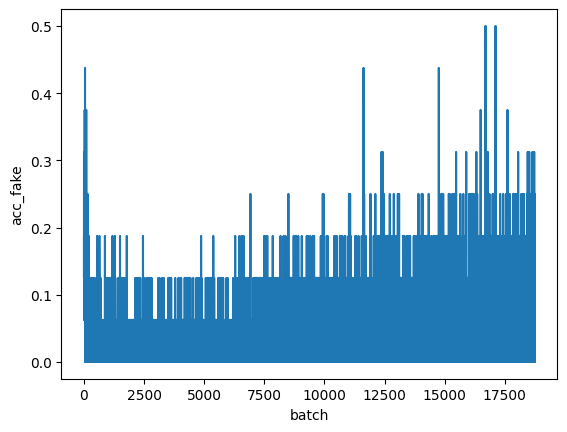

In [7]:
plt.figure()
plt.plot(history["loss_D"])
plt.xlabel('batch')
plt.ylabel('loss_D')

plt.figure()
plt.plot(history["loss_G"])
plt.xlabel('batch')
plt.ylabel('loss_G')

plt.figure()
plt.plot(history["acc_true"])
plt.xlabel('batch')
plt.ylabel('acc_true')

plt.figure()
plt.plot(history["acc_fake"])
plt.xlabel('batch')
plt.ylabel('acc_fake')

tensor(4)


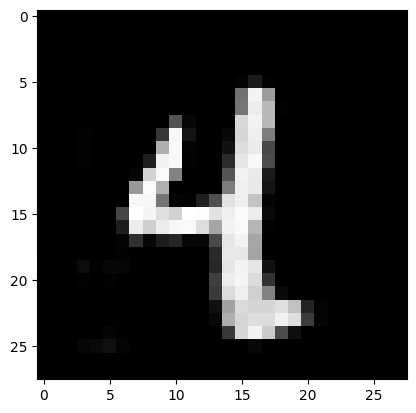

In [8]:
model_G.to("cpu")
with torch.no_grad():
  noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32)
  noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone()
  print(noise_label[0])
  syn_image = model_G(noise, noise_label)
  plt.figure()
  plt.imshow(syn_image.detach().numpy().copy()[0,0,:,:], cmap='gray')

<Figure size 640x480 with 0 Axes>

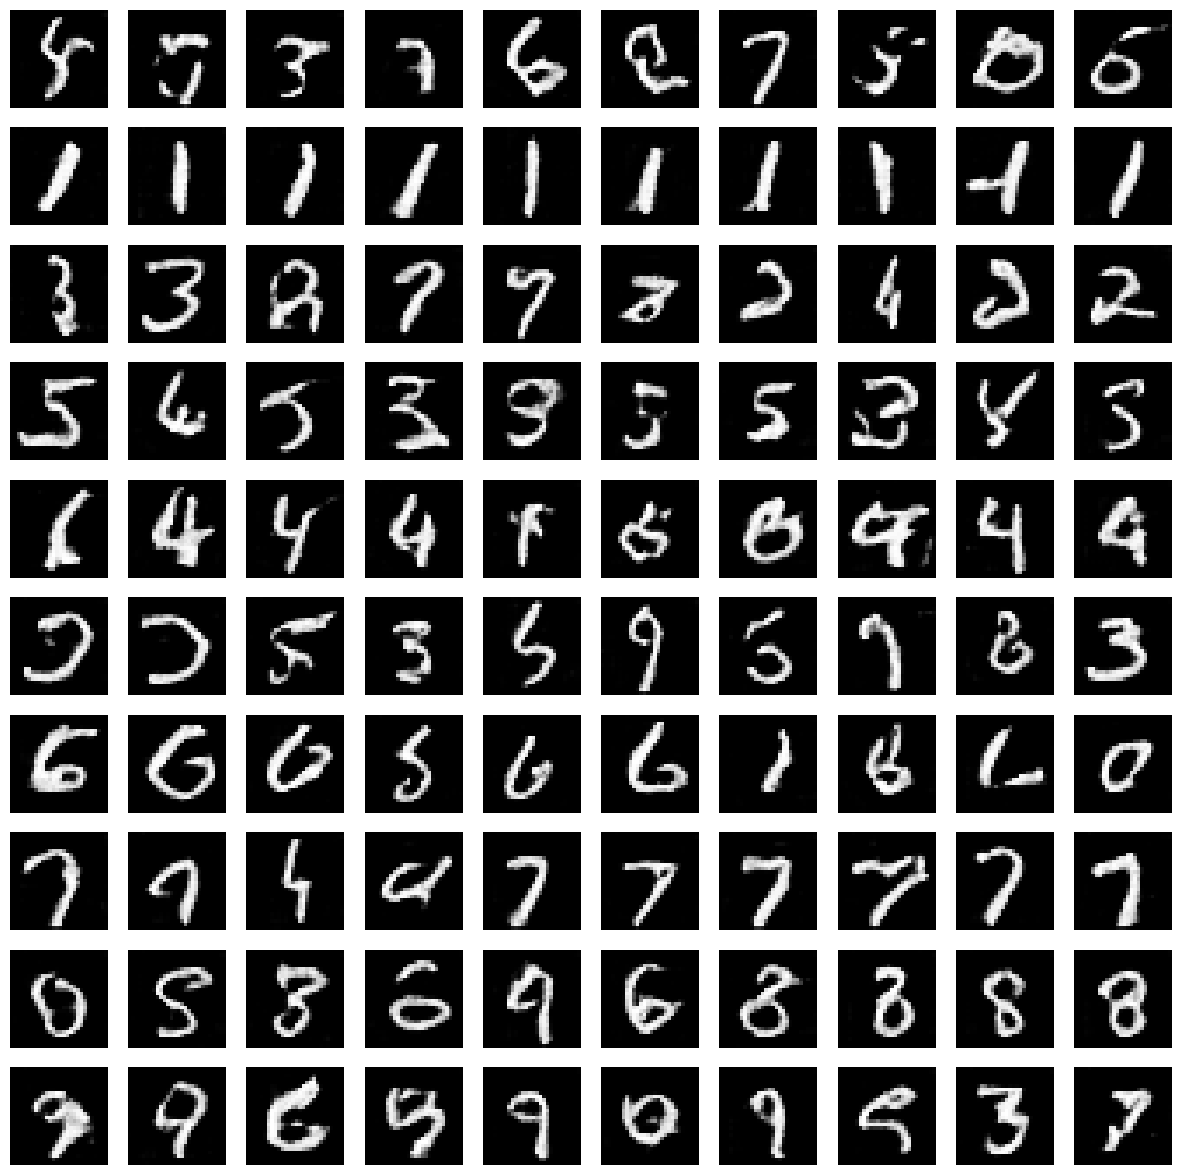

In [9]:
for i in range(10):
  intnp = np.random.randint(i ,i + 1 ,10)
  if i == 0:
    label_np = intnp
  else:
    label_np = np.concatenate([label_np, intnp], 0)

model_G.to("cpu")
with torch.no_grad():
  noise = torch.randn((100, 100), dtype=torch.float32)
  noise_label = torch.from_numpy(label_np).clone()
  syn_image = model_G(noise, noise_label)

  plt.figure()
  fig, ax = plt.subplots(10, 10, figsize=(15,15))
  for i in range(10):
    for j in range(10):
        ax[i,j].imshow(syn_image[i * 10 + j,0,:,:], cmap='gray')
        ax[i,j].axis("off")